# Setup

A bunch of boring setup code that gets the data we're using into a format that's nice and usable! It's not very pretty or useful to show during the talk, so it'll be hidden from "slide mode." Feel free to go exploring through it though!

In [8]:
import json
import random

import numpy as np
import scipy.signal
import astropy.io.fits
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

import sonify

%matplotlib inline

In [9]:
def plot_cleveland_stats(stats):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    ax.set_ylim(ymax=1)
    ax.set_xlabel('Season year')
    ax.set_ylabel('Win Percentage')
    ax.set_title("Cleveland Cavaliers' Regular Season Win Percentage")
    
    ax.annotate("LeBron's Rookie Year", xy=('03/04', 0.427), xytext=(.3, .6),
    arrowprops=dict(facecolor='black', shrink=0.2, width=1),
    )
    ax.annotate("LeBron Leaves for Miami", xy=('10/11', 0.232), xytext=('10/11', 0.05),
        arrowprops=dict(facecolor='black', shrink=0.2, width=1),
    )
    ax.annotate("LeBron Returns to Cleveland", xy=('14/15', 0.646), xytext=('13/14', .9),
        arrowprops=dict(facecolor='black', shrink=0.2, width=1),
    )

    ax.plot(*zip(*stats), 'ro')

In [10]:
def normalize_climate_data(climate_json):
    years = [int(year) for year in climate_json['data'].keys()]
    temp_anomolies = [float(temp_anomaly) for temp_anomaly in climate_json['data'].values()]

    normalized_years = sonify.scale_list_to_range(years, new_min=0, new_max=30)
    normalized_temp_anomolies = sonify.scale_list_to_range(temp_anomolies, new_min=30, new_max=127)


    normed_climate_data = list(zip(normalized_years, normalized_temp_anomolies))
    
    return normed_climate_data

In [11]:
def get_kepler_data():
    """
    Example from @GeertHub's talk on "How to find a planet"
    http://nbviewer.jupyter.org/github/barentsen/how-to-find-a-planet/blob/master/how-to-find-a-planet.ipynb
    """
    # Read in Kepler data for star number 011904151
    data = astropy.io.fits.open('sample_data/kplr011904151-2010009091648_lpd-targ.fits')[1].data
    time = data["TIME"][data['QUALITY'] == 0]
    images = data["FLUX"][data['QUALITY'] == 0]
    
    lightcurve = np.sum(images, axis=(1, 2))
    trend = scipy.signal.savgol_filter(lightcurve, 101, polyorder=3) 
    percent_change = 100 * ((lightcurve / trend) - 1)

    frequency, power = LombScargle(time, percent_change, nterms=2).autopower(minimum_frequency=1/1.5, maximum_frequency=1/0.6, samples_per_peak=10)
    period = 1 / frequency[np.argmax(power)]

    return time, period, percent_change, images

In [12]:
def show_plots_in_chunks():
    n_plots = 10
    plt.figure(figsize=(10, 30))
    for i in range(n_plots):
        mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
        plt.subplot(n_plots, 1, i+1)
        plt.scatter(time[mask], percent_change[mask], c='C{}'.format(i))

In [13]:
def process_kepler_data(time, period, percent_change, low_note=20, high_note=100):    
    
    x_points = []
    y_points = []
    for i in range(10):
        mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
        x_points += [x for x in time[mask] - time[0] - i*period]
        y_points += [y for y in percent_change[mask]]

    normalized_x = sonify.scale_list_to_range(x_points, new_min=0, new_max=30)
    normalized_y = sonify.scale_list_to_range(y_points, new_min=low_note, new_max=high_note)
        
    normed_data = list(zip(normalized_x, normalized_y))
    
    return normed_data

In [14]:
def process_kepler_data_multi_track(time, period, percent_change):
    # Add period as a seperate color so we can see all the data together
    
    points = []
    plt.figure(figsize=(10, 5))
    
    for i in range(5):
        mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
        new_x = [x for x in time[mask] - time[0] - i*period]
        scaled_x = sonify.scale_list_to_range(new_x, new_min=0, new_max=30)
        
        new_y = [y for y in percent_change[mask]]
        scaled_y = sonify.scale_list_to_range(new_y, new_min=0, new_max=30)
        
        quantized_x = sonify.quantize_x_value(scaled_x)
                
        points.append(list(zip(quantized_x, scaled_y)))
        
        # Create the figure!
        mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
        plt.scatter(time[mask] - time[0] - i*period, percent_change[mask])
            
    return points

# Start with some simple data

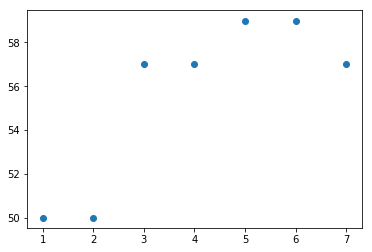

In [15]:
# Create some data we'd like to play from
simple_data = [(1, 50), (2, 50), (3, 57), (4, 57), (5, 59), (6, 59), (7, 57)]

# See what it looks like
plt.scatter(*zip(*simple_data))

In [16]:
sonify.play_midi_from_data(simple_data)

Done playing!


# How are we converting numbers to notes?

## MIDI 	&#9835;
###  Musical Instrument Digital Interface

![midi notes and values](images/midi_notes_values.png)

[source](http://computermusicresource.com/midikeys.html)

# Python has SO MANY great resources for this

[Python in music wiki](https://wiki.python.org/moin/PythonInMusic) just scratches the surface.

For this talk, I'll be using [sonify](https://github.com/erinspace/sonify) -- some code that uses python to convert data to sound

The main components are:

- Midi creation using [midiutil](http://midiutil.readthedocs.io/en/stable/)
- Playing back that midi file using [pygame](https://www.pygame.org/docs/ref/mixer.html)


# Basketball Stats 	&#127936;

Here's some stats for the Cleveland Cavalier's regular season win percentage

In [17]:
cleveland_seasons = [
    ('00/01', 0.366),
    ('01/02', 0.354),
    ('02/03', 0.207),
    ('03/04', 0.427), # LeBron's rookie year
    ('04/05', 0.512),
    ('05/06', 0.610),
    ('06/07', 0.610),
    ('07/08', 0.549),
    ('08/09', 0.805),
    ('09/10', 0.744),
    ('10/11', 0.232), # LeBron leaves for Miami
    ('11/12', 0.318),
    ('12/13', 0.293),
    ('13/14', 0.402),
    ('14/15', 0.646), # LeBron returns to Cleveland
    ('15/16', 0.695),
    ('16/17', 0.622),
    ('17/18', 0.610)
]

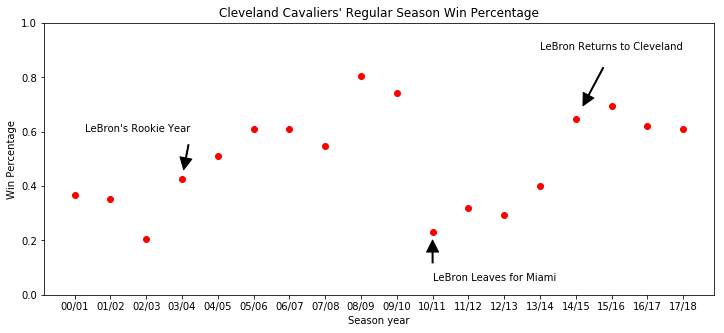

In [18]:
plot_cleveland_stats(cleveland_seasons)

In [19]:
# Do a little processing to play back the data
season, win_percentage = zip(*cleveland_seasons)

# Just use the last year in the season
simple_year = [int(year.split('/')[-1]) for year in season]

# Scale the Y value to fit in a good MIDI note range
normalized_win_percentage = sonify.scale_list_to_range(win_percentage, new_min=30, new_max=127)

# Put it all back together!
processed_cleveland_data = list(zip(simple_year, normalized_win_percentage))

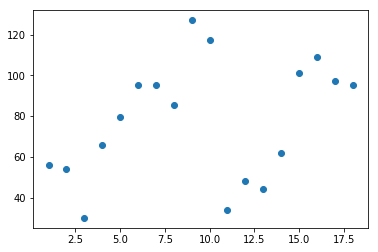

In [20]:
plt.scatter(*zip(*processed_cleveland_data))

In [21]:
sonify.play_midi_from_data(processed_cleveland_data)

Done playing!


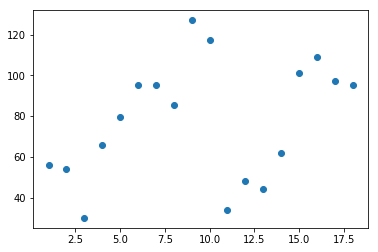

In [22]:
plt.scatter(*zip(*processed_cleveland_data))

In [23]:
sonify.play_midi_from_data(
    ['pizzicato strings'] + processed_cleveland_data, key='g_major'
)

Done playing!


![title](images/climate_data.png)

## "yearly average temperature anomalies"

[source](https://www.climate.gov/maps-data/dataset/global-temperature-anomalies-graphing-tool)

>Comparing the average temperature of land and ocean combined for a year period to the average temperature for the same period over the 20th century shows if conditions are warmer or cooler than the past.

In [24]:
# Climate data from https://www.ncdc.noaa.gov/cag/
with open('sample_data/global_temp_anomolies_1880-2018.json') as data_file:    
    climate_json = json.load(data_file)

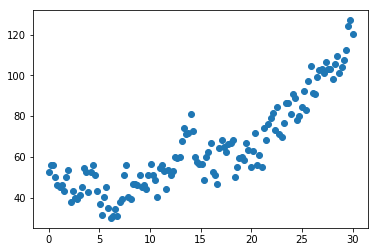

In [25]:
normalized_climate_data = normalize_climate_data(climate_json)
plt.scatter(*zip(*normalized_climate_data))

In [26]:
sonify.play_midi_from_data(['whistle'] + normalized_climate_data)

Done playing!


# Exoplanet Data!  	&#128301;

Let's look at some data from the Kepler Space Telescope.

This will all be a bit of a whirlwind, but it's the data we're after so hang on tight!

We'll be using data and code from Example from Geert Barentsen's talk titled ["How to find a planet](http://nbviewer.jupyter.org/github/barentsen/how-to-find-a-planet/blob/master/how-to-find-a-planet.ipynb)."

The above linked notebook goes into WAY more detail, so if you're interested definitely check it out!

# What Kepler is Looking For
![exoplanet transit](images/transit.gif)

# How Kepler gathers data

>Kepler gives us tiny images of stars at many different timestamps.

This image data is housed inside a file called a FITS file.

To analyze the data, astronomers...
- measure the brightness of each of those images
- record the brightness on a graph
- look for a dip in the brightness of that star
- repeat the brightness observation over many cycles to get a pattern

# Let's look at one of those star images

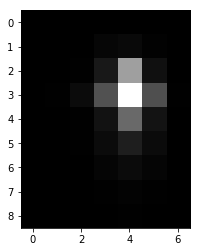

In [28]:
time, period, percent_change, images = get_kepler_data()

plt.imshow(images[0], cmap='gray')

In [29]:
# Overall, this FITS file has 926 9x7-pixel images!
images.shape

(926, 9, 7)

# Find the pattern in all that data

Though a bit of signal processing, you can tell that something seems to be happening in the brightness of the signal every 0.8 days!

Let's plot the data in 0.8-day chunks.

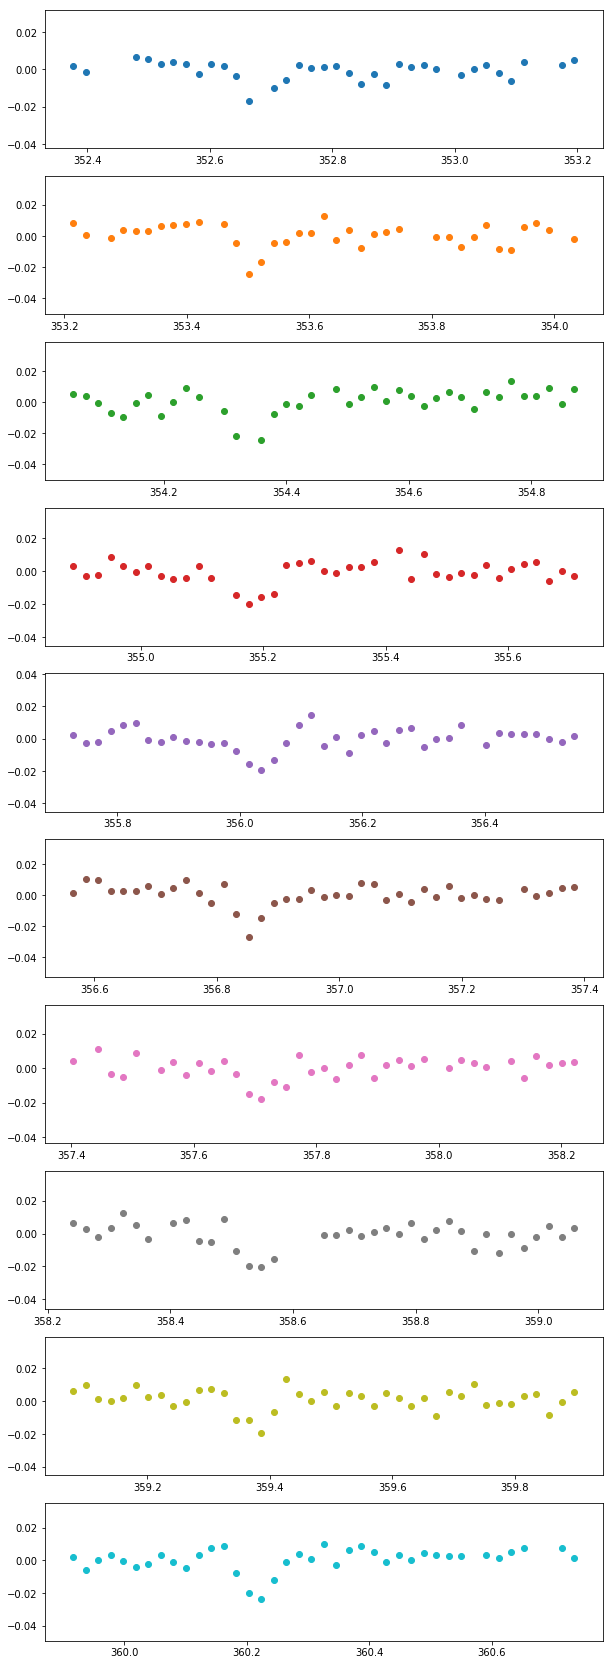

In [30]:
show_plots_in_chunks()

# Process the Signal to use with Sonify!

To process this signal, we will:
- Add each of the points on these 10 periods to the same graph
- Scale the points to a range that makes sense to play back with MIDI data

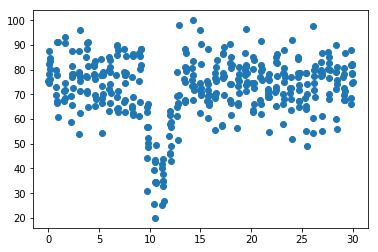

In [31]:
normed_data = process_kepler_data(time, period, percent_change)

plt.scatter(*zip(*normed_data))

In [32]:
sonify.play_midi_from_data(normed_data)

Done playing!


# Let's try playing each seperate lightcurve as a new track!
## And let's add a rhythm while we're at it, why not

## We can make a MIDI file that:
- pairs down the number of observations to 5 for less clutter
- restricts the y values to be all in one key
- treats each period of observations as a new insturment
- quantizes the x values, so that the result is more rhythmic!
- incorperates a beat track to give it a groove

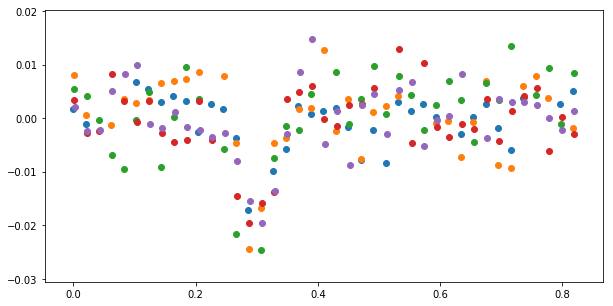

In [33]:
multitrack_data = process_kepler_data_multi_track(time, period, percent_change)

In [34]:
# Let's add some instruments to each track!
instruments_to_add = [
    'steel drums', 'rock organ', 'pizzicato strings', 'oboe', 'ocarina'
]

multitrack_data_with_instruments = []
for index, track in enumerate(multitrack_data):
    multitrack_data_with_instruments.append([instruments_to_add[index]] + track)

In [35]:
# While we're at it, let's add a drum track with a solid beat
max_number_of_beats = multitrack_data_with_instruments[0][-1][0]

bass_drum = []
for beat in range(0, int(max_number_of_beats + 1)):
   bass_drum.append((beat, 1)) 

beat_track = ['bass drum 1'] + bass_drum
multitrack_data_with_instruments.append(beat_track)



<img src="images/kepler_multitrack.png" alt="multi track kepler data" style="width: 500px;"/>

In [36]:
sonify.play_midi_from_data(multitrack_data_with_instruments, track_type='multiple', key='c_major')

Done playing!


# Where to go from here?

Python has so many great music making and data-interpreting resources!

# osf.io/vgaxh

...for resources, contact info, these slides, and the code used to generate everything!

# Data flows around
# Almost everything we do
# Sound sings its story

# Thank you!

<br>
<br>
<br>
<sup><sub>email: erin.braswell@gmail.com</sub></sup><br>
<sup><sub>twitter: @erinspaced</sub></sup><br>
<sup><sub>github: github.com/erinspace</sub></sup><br>
<sup><sub>these slides & more: osf.io/vgaxh</sub></sup>
